In [1]:
import itertools

import multiprocess
import numpy as np
import pymatching
import scipy.optimize
import stim
from matplotlib import pyplot as plt

## Circuit

In [2]:
distance = 5
rounds = 20
circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    distance=distance,
    rounds=rounds,
    after_clifford_depolarization=1e-2,
    after_reset_flip_probability=1e-2,
    before_measure_flip_probability=1e-2,
    before_round_data_depolarization=1e-2,
)
with open("surface-code-timeline.svg", "w") as f:
    f.write(str(circuit.without_noise().diagram("timeline-svg")))

In [3]:
def calc_def(circuit: stim.Circuit, sample: np.ndarray, distance: int, rounds: int):
    res = {}
    for key, (i, j, _) in circuit.get_detector_coordinates().items():
        i = int(i / 2)
        j = int(j / 2)
        if (i, j) not in res:
            res[(i, j)] = [sample[key]]
        else:
            res[(i, j)].append(sample[key])
    heatmap = np.zeros((distance + 1, distance + 1))
    heatmap.fill(np.nan)
    for (i, j), val in res.items():
        if len(val) == rounds + 1:
            heatmap[i, j] = np.mean(val[1:-1])
        else:
            heatmap[i, j] = np.mean(val)
    for key, val in res.items():
        if len(val) == rounds + 1:
            res[key] = np.array([np.arange(rounds + 1), val])
        else:
            res[key] = np.array([np.arange(rounds - 1) + 1, val])
    return res, heatmap

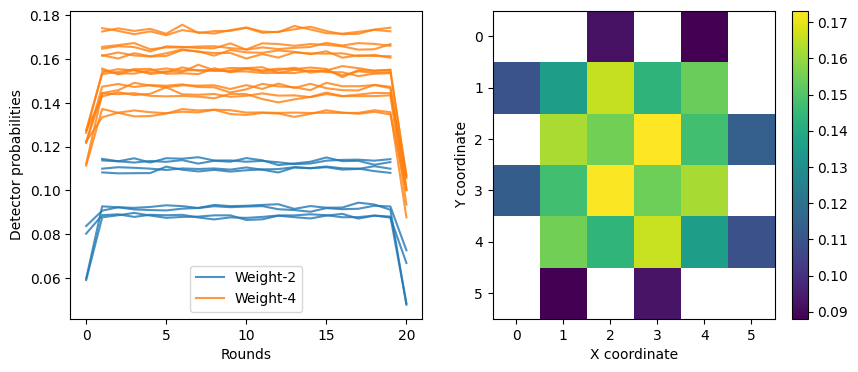

In [4]:
shots = 10**5
detector_sampler = circuit.compile_detector_sampler()
detector_sample = detector_sampler.sample(shots).mean(axis=0)
res, heatmap = calc_def(circuit, detector_sample, distance, rounds)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for key, val in res.items():
    if 0 in key or distance in key:
        axs[0].plot(val[0], val[1], color="C0", alpha=0.8, label="Weight-2")
    else:
        axs[0].plot(val[0], val[1], color="C1", alpha=0.8, label="Weight-4")
axs[0].set_xlabel("Rounds")
axs[0].set_ylabel("Detector probabilities")
handles, labels = axs[0].get_legend_handles_labels()
temp = {k: v for k, v in zip(labels, handles)}
axs[0].legend(temp.values(), temp.keys())

im = axs[1].imshow(heatmap, aspect="auto")
fig.colorbar(im, ax=axs[1])

axs[1].set_xticks(np.arange(0, distance + 1))
axs[1].set_yticks(np.arange(0, distance + 1))
axs[1].set_xlabel("X coordinate")
axs[1].set_ylabel("Y coordinate")

plt.show()

## Logical errors

In [5]:
def count_logical_errors(circuit: stim.Circuit, shots: int) -> float:
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(shots, separate_observables=True)

    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    predictions = matcher.decode_batch(detection_events)
    return np.any(observable_flips != predictions, axis=1).mean()

In [6]:
def calc(distance: int, rounds: int, shots: int, batches: int = 10) -> tuple[float, float]:
    circuit = stim.Circuit.generated(
        "surface_code:rotated_memory_z",
        distance=distance,
        rounds=rounds,
        after_clifford_depolarization=1e-3,
        after_reset_flip_probability=1e-3,
        before_measure_flip_probability=1e-3,
        before_round_data_depolarization=1e-3,
    )
    res = [count_logical_errors(circuit, shots) for _ in range(batches)]
    return np.mean(res), np.std(res)

In [7]:
distances = np.array([3, 5, 7])
rounds = np.arange(20) + 1
shots = 10**5

In [8]:
%%time
with multiprocess.Pool(16) as p:
    res = p.map(
        lambda t: calc(t[0], t[1], shots),
        itertools.product(distances, rounds)
    )
res = np.reshape(res, (len(distances), len(rounds), 2))
print(res.shape)

(3, 20, 2)
CPU times: user 39.6 ms, sys: 63.5 ms, total: 103 ms
Wall time: 41 s


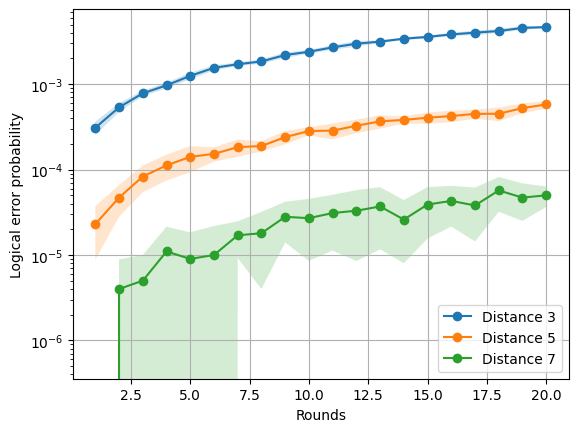

In [9]:
for i in range(len(distances)):
    y = res[i, :, 0]
    y1, y2 = y - res[i, :, 1], y + res[i, :, 1]
    plt.semilogy(rounds, y, marker='o', label=f'Distance {distances[i]}')
    plt.fill_between(rounds, y1, y2, alpha=0.2)
plt.xlabel("Rounds")
plt.ylabel("Logical error probability")
plt.legend()
plt.grid()
plt.show()

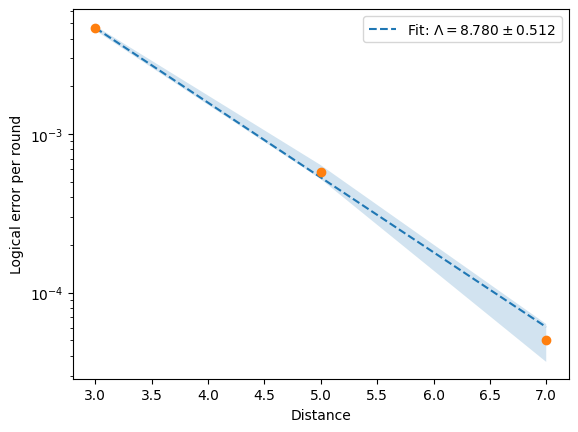

In [10]:
def fit(d, Λ, C):
    return C / Λ ** ((d + 1) / 2)

y, y_err = res[:, -1, 0], res[:, -1, 1]
popt, pcov = scipy.optimize.curve_fit(fit, distances, y, sigma=y_err, absolute_sigma=True)

plt.semilogy(distances, fit(distances, *popt), "--", label=f"Fit: $\\Lambda = {popt[0]:.3f}\\pm{pcov[0, 0]:.3f}$")
plt.semilogy(distances, y, "o")
plt.fill_between(distances, y - y_err, y + y_err, alpha=0.2)
plt.xlabel("Distance")
plt.ylabel("Logical error per round")

plt.legend()
plt.show()